# Simulation for the JWST NIRCam imaging QSO at redshift z~6

Perform this notebook requires standard astroconda libraries and the publicly available packages on github.

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)

This notebook has been tested with on Python 3.6.10, lenstronomy 1.3.0. 

Running this notebook will produce a simulation into a new folder named: sim_ID_0/

### Note that this notebook only simulated the dither image and the drizzling process should be done separately using IRAF


In [1]:
# import the necessary python modules
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.cosmology import FlatLambdaCDM
import glob

from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LightModel.light_model import LightModel

import sys
sys.path.insert(0, '../share_tools')

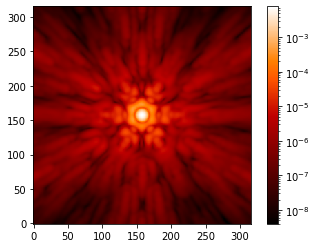

In [2]:
#Setting up the observation condition

nc_filter = 'F444W'
oversample = 4
numPix = 321   # total frame pixel size
z_s = 6.0      #AGN redshift
zp = 28.       #Using ETC to estimate the zeropoint of the filter.

host_mag = 23.797 #Estimated based on 10.3 log(/M_sun) stellar mass.
ID= 10  #The ID for this simulation
np.random.seed(seed = ID)

host_flux = 10**(0.4*(zp - host_mag))
host_ratio = np.random.uniform(0.4, 0.7) #Set the random host flux ratio [40% - 70%].
point_flux = host_flux/host_ratio - host_flux #Calculate the point source flux.

host_n = np.random.uniform(1, 4)   #Host effective radius, unit: Kpc
host_Reff_kpc = 2.0   #Host effective radius, unit: Kpc
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

#Generate PSF using webbpsf:
psf_name = 'psf_{0}_sub{1}.fits'.format(nc_filter, oversample)
if glob.glob(psf_name) == []:
    import webbpsf
    nc = webbpsf.NIRCam()
    nc.filter =  nc_filter
    print("Generate PSF higher resolution by factor of 4:")
    psf = nc.calc_psf(oversample=oversample)     # returns an astropy.io.fits.HDUlist containing PSF and header
    pyfits.PrimaryHDU(psf[0].data,header=psf[0].header).writeto(psf_name,overwrite=False)
psf = pyfits.open(psf_name)
plt.imshow(psf[0].data, origin='lower',cmap='gist_heat', norm=LogNorm())
plt.colorbar()
plt.show()

In [3]:
#%%Build up the simulation:
pix_s = psf[0].header['PIXELSCL'] #* oversample
scale_relation = cosmo.angular_diameter_distance(z_s).value * 10**3 * (1/3600./180.*np.pi)  #Kpc/arc

host_Reff = host_Reff_kpc/scale_relation   #In arcsec

sim_folder_name = 'sim_ID_'+repr(ID)

import os
if os.path.exists(sim_folder_name)==True:
    import shutil 
    shutil.rmtree(sim_folder_name)
os.mkdir(sim_folder_name)

psf_data = psf[0].data
psf_data = psf_data[1:,1:]
psf_data /= psf_data.sum()
kwargs_psf_high_res = {'psf_type': 'PIXEL', 'kernel_point_source': psf_data, 'pixel_size': pix_s}
kwargs_data_high_res = sim_util.data_configure_simple(numPix, pix_s)
data_class = ImageData(**kwargs_data_high_res)

psf_class = PSF(**kwargs_psf_high_res)
center_x, center_y = np.random.normal(0, pix_s*oversample, 2)

point_amp = point_flux
point_source_list = ['UNLENSED']
pointSource = PointSource(point_source_type_list=point_source_list)
kwargs_ps = [{'ra_image': [center_x], 'dec_image': [center_y], 'point_amp': [point_amp]}]

light_model_list = ['SERSIC_ELLIPSE']
lightModel = LightModel(light_model_list=light_model_list)
q = np.random.uniform(0.5,0.9)
phi = np.random.uniform(0.,2*np.pi)
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}


kwargs_sersic_medi = {'amp': 1. , 'n_sersic': host_n, 'R_sersic': host_Reff/np.sqrt(q), 'e1': e1, 'e2': e2,
                 'center_x': center_x, 'center_y': center_y}
kwargs_host_medi = [kwargs_sersic_medi]
imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                point_source_class=pointSource, kwargs_numerics=kwargs_numerics)
medi_host_flux = np.sum(imageModel.image(kwargs_lens_light=kwargs_host_medi, unconvolved=True))
amp = 1. / medi_host_flux * host_flux


kwargs_sersic = {'amp': amp, 'n_sersic': host_n, 'R_sersic': host_Reff/np.sqrt(q), 'e1': e1, 'e2': e2,
                 'center_x': center_x, 'center_y': center_y}
kwargs_host = [kwargs_sersic]


Simulated data with high resolution:


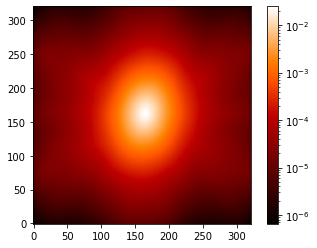

Rebined image to regular resolution :


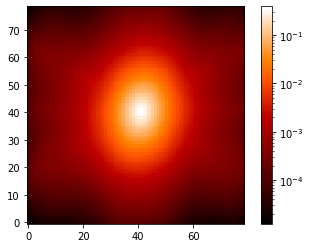

Add noise to the data:


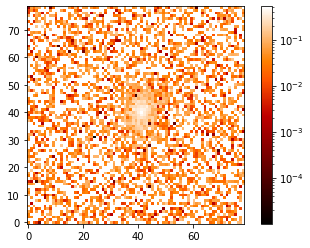

SNR map:


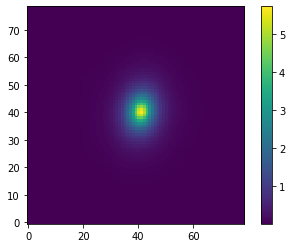

In [4]:
# Generate the simulated image with the parameters we have defined above #
image_host = imageModel.image(kwargs_lens_light=kwargs_host, kwargs_ps=kwargs_ps, unconvolved=False)

print("Simulated data with high resolution:")   
plt.imshow(image_host, origin='lower',cmap='gist_heat', norm=LogNorm())
plt.colorbar()
plt.show()

#Bin the image res. from high to low. 
import rebin #From my share_tools
factor=oversample
pattern_x=[0,2,0,2,1,3,1,3]
pattern_y=[0,0,2,2,3,3,1,1]      #from the info. given by observation
################Bin the lensed image################
exp_grid=rebin.expend_grid(image_host)
cut_out=np.zeros([len(pattern_x),image_host.shape[0]-5,image_host.shape[1]-5])
image_bin =np.zeros([len(pattern_x),int(image_host.shape[0]/factor)-1,int(image_host.shape[1]/factor)-1])
for i in range(len(pattern_x)):
    cut_out[i]=exp_grid[pattern_x[i]:(numPix-5)+pattern_x[i],pattern_y[i]:(numPix-5)+pattern_y[i]]   #the size before bin
    image_bin[i]=rebin.block(cut_out[i],(int(numPix/factor)-1,int(numPix/factor)-1),factor=factor)

print("Rebined image to regular resolution :")    
plt.imshow(image_bin[0], origin='lower',cmap='gist_heat', norm=LogNorm())
plt.colorbar()
plt.show()

################Bin the PSF and save it################
#exp_psf=rebin.expend_grid(psf_pixel_high_res)
cut_fd=int((len(psf_data)-((int(len(psf_data)/8*2)-1)*4+3))/2)
exp_psf_o=psf_data[1+cut_fd:-cut_fd,1+cut_fd:-cut_fd]+ 0  # To change it from 251 to 247.
exp_psf=rebin.expend_grid(exp_psf_o)
cut_len=int(round(len(exp_psf_o)/factor)*factor)
cut_out_psf=np.zeros([len(pattern_x),cut_len,cut_len])
image_bin_psf=np.zeros([len(pattern_x),int(cut_len/factor),int(cut_len/factor)])
for i in range(len(pattern_x)):
    cut_out_psf[i]=exp_psf[pattern_x[i]:cut_len+pattern_x[i],pattern_y[i]:cut_len+pattern_y[i]]   #the size before bin
    image_bin_psf[i]=rebin.block(cut_out_psf[i],(int(cut_len/factor),int(cut_len/factor)),factor=factor)
    image_bin_psf[i] /= np.sum(image_bin_psf[i])  #unify the psf value
    pyfits.PrimaryHDU(image_bin_psf[i]).writeto(sim_folder_name+'/non_drizzled_psf-{0}.fits'.format(i+1),overwrite=False)

#==============================================================================
# Add the noise same as Ding et al. 2017a 
######Since two long pics only ###########
#==============================================================================
bf_noz = image_bin#input simulate data to bf_noz
rms = np.zeros_like(image_bin) #input rms
noiz = np.zeros_like(image_bin) #input noiz
image_data_noise=np.zeros_like(image_bin) #image after noiz
#stdd=0.016  #!!! Need to be confirmed For 10000s, ~0.016. 
#stdd=0.02 #!!! Need to be confirmed For 5000s, ~0.02. 
#stdd=0.042  #!!! Need to be confirmed For 1250s, ~0.042. 
#stdd=0.07  #!!! Need to be confirmed For 579.79s, ~0.07 

exptim= 625.   #exposure time for a dirthered image. Eight dirthered image in total Units of seconds.
stdd = 1.6/np.sqrt(exptim)   #An empirical formula from ETC

for i in range(len(pattern_x)):
    rms[i]=(bf_noz[i]/(exptim)+stdd**2)**0.5 #RMS not saved, thus its value not used here
    bkg_noise= stdd
    noiz[i]=np.random.normal(0, bkg_noise, size=rms[i].shape)
    image_data_noise[i]=noiz[i]+np.random.poisson(lam=bf_noz[i]*exptim)/(exptim)  #Non-drizzled imaged
    pyfits.PrimaryHDU(image_data_noise[i]).writeto(sim_folder_name+'/non_drizzled-image-{0}.fits'.format(i+1),overwrite=False)

print("Add noise to the data:")
plt.imshow(image_data_noise[0], origin='lower',cmap='gist_heat', norm=LogNorm())
plt.colorbar()
plt.show()

print("SNR map:")
plt.imshow(image_bin[0]/rms[0], origin='lower')#,cmap='gist_heat', norm=LogNorm())
plt.colorbar()
plt.show()

In [5]:
# Save the simulation parameters.
filename_ascii = sim_folder_name+'/sim_info.txt'
data_info =  open(filename_ascii,'w') 
data_info.write("Filter:\t{0}\n".format(nc_filter))
data_info.write("Assumed exposure per frame:\t{0} (s)\n".format(exptim))
data_info.write("oversample:\t{0}\n".format(oversample))     
data_info.write("z_s:\t{0}\n".format(z_s))
data_info.write("host position (x, y):\t({0}, {1}) arcsec\n".format(round(center_x,5),round(center_y,5))) 
data_info.write("host_mag (within frame):\t{0}\n".format(round(host_mag,3)))  
data_info.write("host_flux (within frame):\t{0}\n".format(round(host_flux,3)))   
data_info.write("host (phi, q):\t({0}, {1}) arcsec\n".format(round(phi,3),round(q,3))) 
data_info.write("host_n:\t{0}\n".format(host_n))
data_info.write("host_Reff_kpc:\t{0}\n".format(host_Reff_kpc)) 
data_info.write("host_Reff:\t{0} arcsec\n".format(round(host_Reff,5))) 
data_info.write("AGN_flux:\t{0}\n".format(point_flux))
data_info.write("AGN position (x, y):\t({0}, {1}) arcsec\n".format(round(center_x,5),round(center_y,5))) 
data_info.close()
